In [1]:
import reader
import numpy as np
import pandas as pd
import os

First read in the original data

In [2]:
import re
data = pd.read_pickle(os.getcwd() + '/data/all_encounter_data.pickle')

repeat the processing with all_encounter_data in ICO.py

In [3]:
d_enc = data.drop(["Enc_ID","Person_ID"], axis=1)

pattern0= re.compile("\d+\s*\/\s*\d+")
index1 = d_enc['Glucose'].str.contains(pattern0, na=False)
temp = d_enc.loc[index1, 'Glucose']
d_enc.loc[index1, 'Glucose'] = d_enc.loc[index1, 'BP']
d_enc.loc[index1, 'BP'] = temp

index2 = d_enc.BP[d_enc.BP.notnull()][~d_enc.BP[d_enc.BP.notnull()].str.contains('/')].index
temp = d_enc.loc[index2, 'Glucose']
d_enc.loc[index2, 'Glucose'] = d_enc.loc[index2, 'BP']
d_enc.loc[index2, 'BP'] = temp

# Split up the BP field into Systolic and Diastolic readings
pattern1 = re.compile("(?P<BP_Systolic>\d+)\s*\/\s*(?P<BP_Diastolic>\d+)")
d_enc = pd.merge(d_enc, d_enc["BP"].str.extract(pattern1, expand=True),
                 left_index=True, right_index=True).drop("BP", axis=1)

# Define ranges for reasonable values. Identify the data outside of 1.5 times of IQR as outliers
NaN = float("NaN")
quantitive_columns=['A1C', 'BMI', 'Glucose', 'BP_Diastolic', 'BP_Systolic']

In [4]:
for column in quantitive_columns:
    d_enc[column] = pd.to_numeric(d_enc[column], errors='coerce')
    temp = d_enc[column][d_enc[column].notnull()]
    
    Q2 = temp.quantile(0.75)
    Q1 = temp.quantile(0.25)
    IQR = Q2-Q1
        
    print(temp[Q1 - 2 * IQR < temp][temp[Q1 - 2 * IQR < temp] < Q2 + 2 * IQR].shape[0], temp.shape[0], d_enc.shape[0])
    print(column, Q1 - 2 * IQR, Q2 + 2 * IQR)

(11850, 12793, 82432)
('A1C', 2.6000000000000005, 11.6)
(21888, 22198, 82432)
('BMI', 8.319999999999993, 55.29500000000001)
(29150, 30461, 82432)
('Glucose', 16.0, 246.0)
(37922, 38226, 82432)
('BP_Diastolic', 40.0, 115.0)
(37758, 38226, 82432)
('BP_Systolic', 74.0, 194.0)


In [5]:
for column in quantitive_columns:
    d_enc[column] = pd.to_numeric(d_enc[column], errors='coerce')
    temp = d_enc[column][d_enc[column].notnull()]
    
    Q2 = temp.quantile(0.75)
    Q1 = temp.quantile(0.25)
    IQR = Q2-Q1
        
    print(temp[Q1 - 1.5 * IQR < temp][temp[Q1 - 1.5 * IQR < temp] < Q2 + 1.5 * IQR].shape[0], temp.shape[0], d_enc.shape[0])
    print(column, Q1 - 1.5 * IQR, Q2 + 1.5 * IQR)

(11467, 12793, 82432)
('A1C', 3.5000000000000004, 10.7)
(21566, 22198, 82432)
('BMI', 13.017499999999995, 50.59750000000001)
(28517, 30461, 82432)
('Glucose', 39.0, 223.0)
(37383, 38226, 82432)
('BP_Diastolic', 47.5, 107.5)
(37164, 38226, 82432)
('BP_Systolic', 86.0, 182.0)


After setting up the standard range of outliers, we lost at most 600 points for each variable in all_encounter_data. (And set the times of IQR from 1.5 to 2 does not really remain as many points as I was expecting. So I choose the standard times of 1.5)

And after removing the outliers, the variables seem a lot more normal distributed.

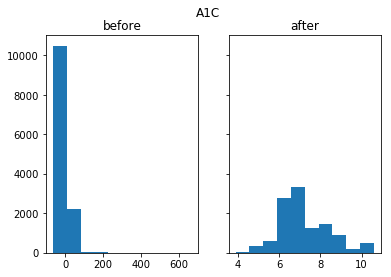

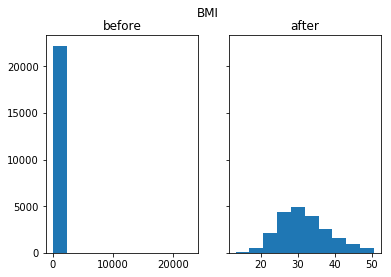

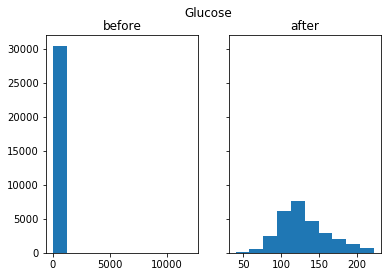

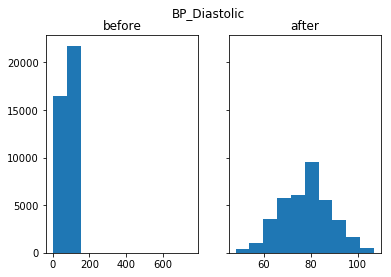

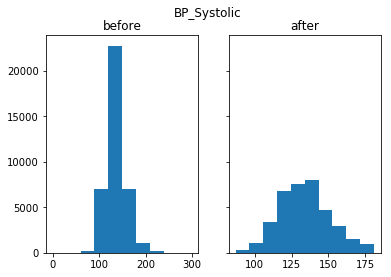

In [6]:
import matplotlib.pyplot as plt
for column in quantitive_columns:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    temp0 = pd.to_numeric(d_enc[column], errors='coerce')
    ax1.hist(temp0[temp0.notnull()])
    ax1.set_title('before')
    
    
    temp = temp0[temp0.notnull()]
    
    Q2 = temp.quantile(0.75)
    Q1 = temp.quantile(0.25)
    IQR = Q2-Q1
        
    d_enc[column] = temp0.map(lambda x: x if Q1 - 1.5 * IQR < x < Q2 + 1.5 * IQR else NaN)
    ax2.hist(d_enc[column][d_enc[column].notnull()])
    ax2.set_title('after')
    
    f.suptitle(column)
    
    
plt.show()

What about we crush all_encounter_data to all_person_data by group Person_Nbr?

In [7]:
person_data_old = pd.read_pickle(os.getcwd() + '/data/all_person_data_Richard_20170307.pickle')
person_data_new = pd.read_pickle(os.getcwd() + '/data/all_person_data_Dan_20170406.pickle')

In [8]:
person_data_old[quantitive_columns].isnull().sum(axis=0)/person_data_old.shape[0]

A1C             0.683896
BMI             0.584450
Glucose         0.329509
BP_Diastolic    0.091714
BP_Systolic     0.091839
dtype: float64

In [9]:
person_data_new[quantitive_columns].isnull().sum(axis=0)/person_data_new.shape[0]

A1C             0.706465
BMI             0.596421
Glucose         0.365422
BP_Diastolic    0.103809
BP_Systolic     0.104807
dtype: float64

From above we can tell, after I identify the outliers, no more than 4% points of each variable are removed, which is acceptable for me.

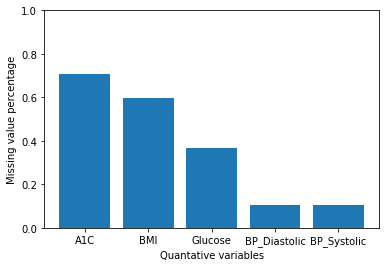

In [10]:
plt.bar(range(0,5),
        person_data_new[quantitive_columns].isnull().sum(axis=0)/person_data_new.shape[0])
plt.gca().set_ylim([0,1])
plt.xticks(range(0,5), quantitive_columns)
plt.ylabel('Missing value percentage')
plt.xlabel('Quantative variables')
plt.show()

## Get the dummy value for the categorical features

In [11]:
dummy_columns = ['DM', 'ME', 'Glaucoma_Suspect', 'Open_angle_Glaucoma', 'Cataract']
categorical_columns = ['Gender', 'Race']
for column in categorical_columns:
    temp = pd.get_dummies(person_data_new[column], prefix=column)
    person_data_new[temp.columns.values]=temp
    dummy_columns.extend(temp.columns.values.tolist())

## Group the quantitive features by Age and Gender
But there are still null values within the grouped mean values.

In [12]:
temp = person_data_new.copy()
mean_value = temp.groupby(['Gender', pd.cut(temp['Age'], 6)]).apply(
    lambda x: x['A1C'][x['A1C'].notnull()].mean())
missing_index = temp.groupby(['Gender', pd.cut(temp['Age'], 6)]).apply(
    lambda x: x['A1C'][x['A1C'].isnull()])
for i in mean_value.index.to_series().tolist():
    if i in missing_index.index:
        temp.set_value(missing_index[i].index, 'A1C', mean_value[i])

In [13]:
mean_value

Gender  Age         
F       (17.904, 34]    7.539483
        (34, 50]        7.473878
        (50, 66]        7.292831
        (66, 82]        6.949700
        (82, 98]        6.800847
        (98, 114]            NaN
M       (17.904, 34]    7.542628
        (34, 50]        7.567414
        (50, 66]        7.248448
        (66, 82]        7.042823
        (82, 98]        6.968860
        (98, 114]            NaN
U       (17.904, 34]         NaN
        (34, 50]             NaN
        (50, 66]        8.500000
        (66, 82]             NaN
dtype: float64

In [14]:
temp[temp['A1C'].isnull()].shape[0]

14

## Group the quantitive features by Age_group (and maybe gender)

Divide patients into groups with same amount of patients by age and created a new column called Age_group

### Divide patients into groups by quantile of age and get dummy values 

In [15]:
age_group = np.array([person_data_new.Age.quantile(1.0/6*i) for i in range(1,7)])

In [16]:
age_group

array([  49.,   56.,   61.,   67.,   75.,  114.])

In [17]:
person_data_new['Age_group_numeric']=person_data_new.Age.apply(lambda x: sum(age_group<x)+1)

In [18]:
age_group_dict = {1: '(18, 48]', 2: '(49, 55]', 3: '(56, 60]', 4: '(61, 66]', 5: '(67, 74]', 6: '(75, 114]'}
person_data_new['Age_group'] = person_data_new.Age_group_numeric.apply(lambda x: age_group_dict.get(x))

In [19]:
person_data_new.groupby('Age_group').apply(lambda x: x.shape[0])

Age_group
(18, 48]     2882
(49, 55]     2779
(56, 60]     2465
(61, 66]     2723
(67, 74]     2544
(75, 114]    2646
dtype: int64

In [20]:
temp = pd.get_dummies(person_data_new['Age_group'], prefix = 'Age_group')
person_data_new[temp.columns.values] = temp
dummy_columns.extend(temp.columns.values.tolist())

### The missing value percentage in different age group as following:

In [21]:
person_data_new.groupby('Age_group').apply(lambda x: x[quantitive_columns].isnull().sum(axis=0)/x.shape[0])

,A1C,BMI,Glucose,BP_Diastolic,BP_Systolic
Age_group,,,,,
"(18, 48]",0.680083,0.553088,0.416724,0.134282,0.121096
"(49, 55]",0.682979,0.565671,0.374955,0.095358,0.093559
"(56, 60]",0.690061,0.595538,0.367546,0.088438,0.090872
"(61, 66]",0.675725,0.602277,0.354021,0.088138,0.091811
"(67, 74]",0.704009,0.648978,0.309748,0.097091,0.104953
"(75, 114]",0.809146,0.620181,0.362812,0.116402,0.125094


### Implement ANOVA test
To test if the mean values of the each feature are equal after being grouped

In [22]:
from scipy.stats import f_oneway

In [23]:
for column in quantitive_columns:
    temp = {k:list(v[column]) for k,v in person_data_new[person_data_new[column].notnull()].groupby('Age_group_numeric')}
    print column
    print f_oneway(temp[1], temp[2], temp[3], temp[4], temp[5], temp[6])

A1C
F_onewayResult(statistic=26.371771578908884, pvalue=2.2829101727302631e-26)
BMI
F_onewayResult(statistic=78.631909489798105, pvalue=2.5281219635747063e-80)
Glucose
F_onewayResult(statistic=35.123917937562318, pvalue=9.5112179417179683e-36)
BP_Diastolic
F_onewayResult(statistic=176.9193371566318, pvalue=2.5176503822653756e-183)
BP_Systolic
F_onewayResult(statistic=49.171108345538109, pvalue=1.1760769627946283e-50)


In [24]:
for column in quantitive_columns:
    temp = {k:list(v[column]) for k,v in person_data_new[person_data_new[column].notnull()].groupby('Gender')}
    print column
    print f_oneway(temp['F'], temp['M'])

A1C
F_onewayResult(statistic=1.4508634183063212, pvalue=0.22845005980287483)
BMI
F_onewayResult(statistic=180.05607155798691, pvalue=1.6344154452887715e-40)
Glucose
F_onewayResult(statistic=27.152720231647105, pvalue=1.9168366445098947e-07)
BP_Diastolic
F_onewayResult(statistic=66.008229158879161, pvalue=4.8540258014637313e-16)
BP_Systolic
F_onewayResult(statistic=0.13518260552612232, pvalue=0.71312333853157739)


### Fill up the missing values
with the mean of the non-null variable grouped by age group

In [25]:
person_data_fillup = {}

In [26]:
temp = person_data_new.copy()
for column in quantitive_columns:
    mean_value = temp.groupby('Age_group').apply(
        lambda x: x[column][x[column].notnull()].mean())
    missing_index = temp.groupby('Age_group').apply(
        lambda x: x[column][x[column].isnull()])
    for i in mean_value.index.to_series().tolist():
        if i in missing_index.index:
            temp.set_value(missing_index[i].index, column, mean_value[i])
person_data_fillup['groupbyAgegroup_mean'] = temp

## Group the quantitive features by DR diagnosis

### The missing value percentage in different diagnosis as following:

In [27]:
person_data_new.groupby('recent_DR').apply(lambda x: x.shape[0])

recent_DR
MNPDR      654
PDR        964
SNPDR      198
mNPDR     2214
no_DR    12009
dtype: int64

In [28]:
person_data_new.groupby('recent_DR').apply(lambda x: x[quantitive_columns].isnull().sum(axis=0)/x.shape[0])

,A1C,BMI,Glucose,BP_Diastolic,BP_Systolic
recent_DR,,,,,
MNPDR,0.631498,0.524465,0.249235,0.059633,0.064220
PDR,0.644191,0.581950,0.221992,0.125519,0.134855
SNPDR,0.712121,0.505051,0.303030,0.085859,0.075758
mNPDR,0.645438,0.615628,0.277326,0.065944,0.070912
no_DR,0.726705,0.599467,0.400533,0.111750,0.111333


In [29]:
person_data_new.groupby('worst_DR').apply(lambda x: x.shape[0])

worst_DR
MNPDR      711
PDR       1040
SNPDR      224
mNPDR     2055
no_DR    12009
dtype: int64

In [30]:
person_data_new.groupby('worst_DR').apply(lambda x: x[quantitive_columns].isnull().sum(axis=0)/x.shape[0])

,A1C,BMI,Glucose,BP_Diastolic,BP_Systolic
worst_DR,,,,,
MNPDR,0.613221,0.545710,0.244726,0.053446,0.059072
PDR,0.642308,0.584615,0.221154,0.120192,0.130769
SNPDR,0.691964,0.526786,0.276786,0.075893,0.071429
mNPDR,0.654501,0.609732,0.284672,0.069586,0.072993
no_DR,0.726705,0.599467,0.400533,0.111750,0.111333


### Implement ANOVA test
To test if the mean values of the each feature are equal after being grouped 

In [31]:
for column in quantitive_columns:
    temp = {k:list(v[column]) for k,v in person_data_new[person_data_new[column].notnull()].groupby('recent_DR')}
    print column
    print f_oneway(temp['PDR'], temp['SNPDR'], temp['MNPDR'], temp['mNPDR'], temp['no_DR'])

A1C
F_onewayResult(statistic=42.456564864690357, pvalue=4.9175526790653143e-35)
BMI
F_onewayResult(statistic=7.9483011303806936, pvalue=2.1822365886499604e-06)
Glucose
F_onewayResult(statistic=18.394389549816427, pvalue=4.5149589422910206e-15)
BP_Diastolic
F_onewayResult(statistic=8.6619398405301098, pvalue=5.5900999918337789e-07)
BP_Systolic
F_onewayResult(statistic=56.945191077184248, pvalue=9.5480751841461601e-48)


### Fill up the missing values 
with the mean of the non-null variable grouped by DR diagnosis

In [32]:
DR_diagnoses = ['PDR', 'SNPDR', 'MNPDR', 'mNPDR', 'no_DR']

In [33]:
temp = person_data_new.copy()
for column in quantitive_columns:
    mean_value = temp.groupby('recent_DR').apply(lambda x: x[column][x[column].notnull()].mean())
    missing_index = temp.groupby('recent_DR').apply(lambda x: x[column][x[column].isnull()])
    for diagnosis in DR_diagnoses:
        temp.set_value(missing_index[diagnosis].index, column, mean_value[diagnosis])
person_data_fillup['recent_groupbyDR_mean'] = temp

In [34]:
temp = person_data_new.copy()
for column in quantitive_columns:
    mean_value = temp.groupby('worst_DR').apply(lambda x: x[column][x[column].notnull()].mean())
    missing_index = temp.groupby('worst_DR').apply(lambda x: x[column][x[column].isnull()])
    for diagnosis in DR_diagnoses:
        temp.set_value(missing_index[diagnosis].index, column, mean_value[diagnosis])
person_data_fillup['worst_groupbyDR_mean'] = temp

## Modeling trial

### Varibles

In [35]:
dummy_columns

['DM',
 'ME',
 'Glaucoma_Suspect',
 'Open_angle_Glaucoma',
 'Cataract',
 'Gender_F',
 'Gender_M',
 'Gender_U',
 'Race_Asian',
 'Race_Black or African American',
 'Race_Hispanic or Latino',
 'Race_Other Race',
 'Race_Two or More Races',
 'Race_Unknown',
 'Race_White',
 'Age_group_(18, 48]',
 'Age_group_(49, 55]',
 'Age_group_(56, 60]',
 'Age_group_(61, 66]',
 'Age_group_(67, 74]',
 'Age_group_(75, 114]']

In [36]:
quantitive_columns

['A1C', 'BMI', 'Glucose', 'BP_Diastolic', 'BP_Systolic']

In [37]:
target_columns = {'recent_groupbyDR_mean': 'recent_DR', 
                  'worst_groupbyDR_mean': 'worst_DR',
                  'groupbyAgegroup_mean': 'recent_DR'}

### Decision Tree modeling exploration

In [38]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [39]:
for method, temp in person_data_fillup.items():
    print(method)
    
    X = temp[quantitive_columns + dummy_columns]
    y = temp[target_columns[method]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)

    preds = clf.predict(X = X_test)

    #preds = label_encoder.inverse_transform(preds.tolist())
    #y_test = label_encoder.inverse_transform(y_test)

    print(pd.crosstab(y_test, preds))
    print(metrics.classification_report(y_true = y_test, y_pred=preds))


groupbyAgegroup_mean
col_0      MNPDR  PDR  SNPDR  mNPDR  no_DR
recent_DR                                 
MNPDR         19   35      6     47    101
PDR           31   52     10     69    150
SNPDR          6   10      4     12     26
mNPDR         43   72     16    138    456
no_DR        126  186     44    501   3133
             precision    recall  f1-score   support

      MNPDR       0.08      0.09      0.09       208
        PDR       0.15      0.17      0.16       312
      SNPDR       0.05      0.07      0.06        58
      mNPDR       0.18      0.19      0.18       725
      no_DR       0.81      0.79      0.80      3990

avg / total       0.65      0.63      0.64      5293

recent_groupbyDR_mean
col_0      MNPDR  PDR  SNPDR  mNPDR  no_DR
recent_DR                                 
MNPDR        173    5      2      8     20
PDR            8  268      3     11     22
SNPDR          2    1     48      2      5
mNPDR          5    8      0    665     47
no_DR         26   31   

In [40]:
tree.export_graphviz(clf, feature_names = quantitive_columns + dummy_columns,
                     class_names = ['MNPDR','PDR','SNPDR','mNPDR','no_DR'], out_file='DT.dot') 

### Logistic Regression modeling exploration

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
for method, temp in person_data_fillup.items():
    print(method)
    
    X = temp[quantitive_columns + dummy_columns]
    y = temp[target_columns[method]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    clf = LogisticRegression()
    clf = clf.fit(X_train, y_train)

    preds = clf.predict(X = X_test)

    #preds = label_encoder.inverse_transform(preds.tolist())
    #y_test = label_encoder.inverse_transform(y_test)

    print(pd.crosstab(y_test, preds))
    print(metrics.classification_report(y_true = y_test, y_pred=preds))


groupbyAgegroup_mean
col_0      MNPDR  PDR  SNPDR  mNPDR  no_DR
recent_DR                                 
MNPDR          5   46      0     24    133
PDR            3   57      0     37    215
SNPDR          0   23      0      5     30
mNPDR          5   53      1     35    631
no_DR          0   25      0     13   3952
             precision    recall  f1-score   support

      MNPDR       0.38      0.02      0.05       208
        PDR       0.28      0.18      0.22       312
      SNPDR       0.00      0.00      0.00        58
      mNPDR       0.31      0.05      0.08       725
      no_DR       0.80      0.99      0.88      3990

avg / total       0.67      0.76      0.69      5293

recent_groupbyDR_mean
col_0      MNPDR  PDR  SNPDR  mNPDR  no_DR
recent_DR                                 
MNPDR          5   40      0     38    125
PDR            4   60      0     38    210
SNPDR          0   19      0     10     29
mNPDR          4   43      1     63    614
no_DR          2   20   

## Output the filled up data

In [43]:
temp = person_data_fillup['groupbyAgegroup_mean'][quantitive_columns + dummy_columns + ['worst_DR', 'recent_DR']]
temp.describe(include='all')

,A1C,BMI,Glucose,BP_Diastolic,BP_Systolic,DM,ME,Glaucoma_Suspect,Open_angle_Glaucoma,Cataract,...,Race_Unknown,Race_White,"Age_group_(18, 48]","Age_group_(49, 55]","Age_group_(56, 60]","Age_group_(61, 66]","Age_group_(67, 74]","Age_group_(75, 114]",worst_DR,recent_DR
count,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039,16039,16039,16039,16039,...,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039,16039
unique,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
top,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_DR,no_DR
freq,NaN,NaN,NaN,NaN,NaN,13321,15021,12439,14554,9170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12009,12009
mean,7.208732,31.770937,131.811752,78.109306,133.602606,NaN,NaN,NaN,NaN,NaN,...,0.256375,0.031486,0.179687,0.173265,0.153688,0.169774,0.158613,0.164973,NaN,NaN
std,0.698271,4.492439,25.716994,9.867409,16.124745,NaN,NaN,NaN,NaN,NaN,...,0.436645,0.174632,0.383939,0.378488,0.360661,0.375446,0.365327,0.371168,NaN,NaN
min,3.900000,14.395000,40.000000,48.000000,87.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,6.900000,28.900000,120.000000,72.000000,123.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,7.203035,31.579036,131.670279,78.082412,133.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,7.367049,33.360000,136.876498,84.000000,142.000000,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [44]:
temp.to_pickle('baseline_missingHandled_Dan_20170406.pickle')

In [49]:
temp = person_data_new[quantitive_columns + dummy_columns + ['worst_DR', 'recent_DR']]
temp.describe(include='all')

,A1C,BMI,Glucose,BP_Diastolic,BP_Systolic,DM,ME,Glaucoma_Suspect,Open_angle_Glaucoma,Cataract,...,Race_Unknown,Race_White,"Age_group_(18, 48]","Age_group_(49, 55]","Age_group_(56, 60]","Age_group_(61, 66]","Age_group_(67, 74]","Age_group_(75, 114]",worst_DR,recent_DR
count,4708.000000,6473.000000,10178.000000,14374.000000,14358.000000,16039,16039,16039,16039,16039,...,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039.000000,16039,16039
unique,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
top,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_DR,no_DR
freq,NaN,NaN,NaN,NaN,NaN,13321,15021,12439,14554,9170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12009,12009
mean,7.235485,31.867714,131.677803,78.109281,133.611368,NaN,NaN,NaN,NaN,NaN,...,0.256375,0.031486,0.179687,0.173265,0.153688,0.169774,0.158613,0.164973,NaN,NaN
std,1.241573,6.785681,32.121431,10.384908,17.023775,NaN,NaN,NaN,NaN,NaN,...,0.436645,0.174632,0.383939,0.378488,0.360661,0.375446,0.365327,0.371168,NaN,NaN
min,3.900000,14.395000,40.000000,48.000000,87.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,6.300000,26.880000,109.500000,70.675000,122.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,7.000000,31.170000,127.000000,78.000000,132.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,8.000000,36.120000,150.000000,85.000000,144.000000,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [48]:
temp.to_pickle('baseline_raw_Dan_20170406.pickle')